In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
import pandas as pd
from utilities_functions.intermediate_layer_extraction import return_layer_input_output
from utilities_functions.ri_calculator import find_smallest_variation_to_change
import deepmatcher as dm
import torch

In [4]:
attributes =['Beer_Name','Brew_Factory_Name','Style','ABV']

In [5]:
model = dm.MatchingModel(attr_summarizer='hybrid')
model.load_state('../models/beer_hybrid.pth')
model.cuda()

MatchingModel(
  (attr_summarizers): ModuleMap(
    (Beer_Name): Hybrid(
      (word_contextualizer): RNN(
        (rnn_groups): ModuleList(
          (0): GRU(300, 150, batch_first=True, bidirectional=True)
        )
        (dropouts): ModuleList(
          (0): Dropout(p=0)
        )
        (bypass_networks): ModuleList(
          (0): None
        )
        (input_dropout): NoMeta(
          (module): Dropout(p=0)
        )
      )
      (word_comparator): Attention(
        (alignment_networks): ModuleList(
          (0): AlignmentNetwork(
            (transform): Transform(
              (transforms): ModuleList(
                (0): Linear(in_features=300, out_features=300, bias=True)
                (1): Linear(in_features=300, out_features=300, bias=True)
              )
              (bypass_networks): ModuleList(
                (0): Bypass(
                  (highway_gate): Linear(in_features=300, out_features=300, bias=True)
                )
                (1): Bypass(


In [6]:
neg_classifier_inputs,neg_classifier_outputs,neg_ids = return_layer_input_output('../Structured/Beer/'
                                                                         ,'negatives.csv',32,model,
                                                                        model.classifier)

In [7]:
testneg_classifier_inputs,testneg_classifier_outputs,testneg_ids = return_layer_input_output('../Structured/Beer/'
                                                                         ,'test_negatives.csv',32,model,
                                                                        model.classifier)

In [8]:
pos_classifier_inputs,pos_classifier_outputs,pos_ids = return_layer_input_output('../Structured/Beer',
                                                                       'positives.csv',32,model,
                                                                       model.classifier)

In [9]:
testpos_classifier_inputs,testpos_classifier_outputs,testpos_ids = return_layer_input_output('../Structured/Beer',
                                                                       'test_positives.csv',32,model,
                                                                       model.classifier)

In [10]:
negative_classifier_inputs = list(map(lambda x: x[0],neg_classifier_inputs))
positive_classifier_inputs = list(map(lambda x: x[0],pos_classifier_inputs))
test_negative_classifier_inputs = list(map(lambda x: x[0],testneg_classifier_inputs))
test_positive_classifier_inputs = list(map(lambda x: x[0],testpos_classifier_inputs))

In [11]:
attribute_length = int((300*3)/len(attributes))
classifier_length = int(attribute_length*len(attributes))

In [12]:
current_sample = 0
#each column of this matrix is related to a specific attribute
negatives_ri_matrix = []
for batch in test_negative_classifier_inputs:
    for sample_index in range(len(batch)):
        print('Processing sample number {}'.format(current_sample))
        current_sample_ris = list(map(lambda att: find_smallest_variation_to_change(model.classifier,
                                                                                    classifier_length=classifier_length,
                                                                                    attribute_length=attribute_length,
                                                                                    input_matrix=batch,
                                                                                    vector_index=sample_index,
                                                                                    attributes=[attributes.index(att)]
                                                                                    ,class_to_reach=1),attributes))
        negatives_ri_matrix.append(current_sample_ris)
        current_sample+=1

Processing sample number 0
Processing sample number 1
Processing sample number 2
Processing sample number 3
Processing sample number 4
Processing sample number 5
Processing sample number 6
Processing sample number 7
Processing sample number 8
Processing sample number 9
Processing sample number 10
Processing sample number 11
Processing sample number 12
Processing sample number 13
Processing sample number 14
Processing sample number 15
Processing sample number 16
Processing sample number 17
Processing sample number 18
Processing sample number 19
Processing sample number 20
Processing sample number 21
Processing sample number 22
Processing sample number 23
Processing sample number 24
Processing sample number 25
Processing sample number 26
Processing sample number 27
Processing sample number 28
Processing sample number 29
Processing sample number 30
Processing sample number 31
Processing sample number 32
Processing sample number 33
Processing sample number 34
Processing sample number 35
Pr

In [13]:
ri_norms_negative_samples = []
for ri_list in negatives_ri_matrix:
    ri_norms_negative_samples.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))

In [14]:
negatives_variation_df = pd.DataFrame(data= ri_norms_negative_samples,columns=attributes)

In [15]:
negatives_variation_df.head(10)

,Beer_Name,Brew_Factory_Name,Style,ABV
0,5.604307,5.477812,6.112682,6.169948
1,1.728643,1.851437,2.652193,2.521036
2,0.000000,0.000000,0.000000,0.000000
3,5.328798,5.218397,5.974388,6.080107
4,5.696321,5.590625,6.139896,6.260335
5,2.119331,2.193049,2.899128,2.833386
6,2.306724,2.336596,2.903321,2.914094
7,1.971653,3.906338,5.557146,5.303346
8,5.418454,5.189224,6.037600,6.101061
9,0.000000,0.000000,0.000000,0.000000


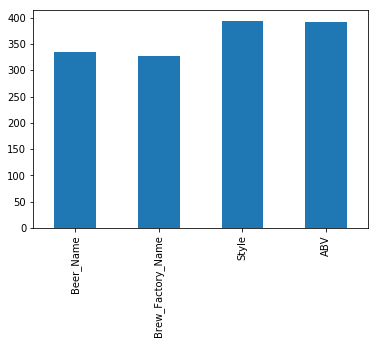

In [17]:
ri_sums = negatives_variation_df.sum(numeric_only=True)
ri_sums.plot.bar()

In [18]:
current_sample = 0
#each column of this matrix is related to a specific attribute
positives_ri_matrix = []
for batch in test_positive_classifier_inputs:
    for sample_index in range(len(batch)):
        print('Processing sample number {}'.format(current_sample))
        current_sample_ris = list(map(lambda att: find_smallest_variation_to_change(model.classifier,
                                                                                    classifier_length=classifier_length,
                                                                                    attribute_length=attribute_length,
                                                                                    input_matrix=batch,
                                                                                    vector_index=sample_index,
                                                                                    attributes=[attributes.index(att)]
                                                                                    ,class_to_reach=0),attributes))
        positives_ri_matrix.append(current_sample_ris)
        current_sample+=1

Processing sample number 0
Processing sample number 1
Processing sample number 2
Processing sample number 3
Processing sample number 4
Processing sample number 5
Processing sample number 6
Processing sample number 7
Processing sample number 8
Processing sample number 9
Processing sample number 10
Processing sample number 11
Processing sample number 12
Processing sample number 13


In [19]:
ri_norms_positives = []
for ri_list in positives_ri_matrix:
    ri_norms_positives.append(list(map(lambda x:torch.norm(x).data[0],ri_list)))

In [20]:
positives_variation_df = pd.DataFrame(data= ri_norms_positives,columns=attributes)

In [21]:
positives_variation_df.head(10)

,Beer_Name,Brew_Factory_Name,Style,ABV
0,2.729655,3.104879,4.856560,4.586966
1,11.462715,9.860800,18.796698,16.249638
2,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000
4,5.813547,6.420204,9.911018,9.458938
5,10.265483,9.826769,18.852398,16.241789
6,4.164436,4.717937,7.326994,6.984956
7,2.805812,3.164358,4.886374,4.618066
8,1.448343,1.597852,2.438663,2.307715
9,1.509881,1.681167,2.507252,2.383385


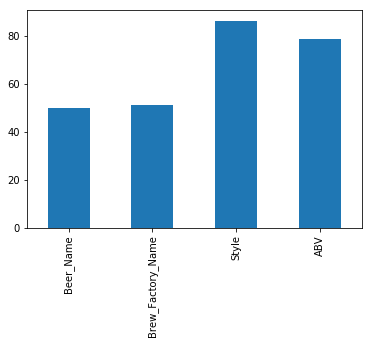

In [22]:
ri_sums = positives_variation_df.sum(numeric_only=True)
ri_sums.plot.bar()

## Compute closer vectors

In [23]:
from utilities_functions.distance_measures import nearest_neighbour,nearest_neighbour_onAttribute

In [25]:
#lista di tuple: vettore più vicino considerando tutti gli elementi e closer solo secondo un attributo
negatives_closer_vectors = []
i = 0
for batch in test_negative_classifier_inputs:
    for sample in batch:
        current_sample_closer_vectors = list(map(lambda att: nearest_neighbour_onAttribute
                                                 (sample+negatives_ri_matrix[i][attributes.index(att)]
                                                                ,positive_classifier_inputs,attributes.index(att),
                                                                attribute_length,'cosine'),attributes))
        negatives_closer_vectors.append(current_sample_closer_vectors)
        i += 1 

In [26]:
# per ogni attributo trovo il più vicino
positives_closer_vectors = []
i = 0
for batch in test_positive_classifier_inputs:
    for sample in batch:
        current_sample_closer_vectors = list(map(lambda att: nearest_neighbour_onAttribute
                                                 (sample+positives_ri_matrix[i][attributes.index(att)]
                                                                ,negative_classifier_inputs,attributes.index(att),
                                                                attribute_length,'cosine'),attributes))
        positives_closer_vectors.append(current_sample_closer_vectors)
        i += 1 

In [27]:
positives_closer_vectors_df = pd.DataFrame(data= positives_closer_vectors,columns =attributes)
positives_closer_vectors_df = positives_closer_vectors_df.applymap(lambda c:neg_ids[c])

In [28]:
negatives_closer_vectors_df = pd.DataFrame(data = negatives_closer_vectors, columns = attributes)
negatives_closer_vectors_df = negatives_closer_vectors_df.applymap(lambda c:pos_ids[c])

In [29]:
positives_closer_vectors_df.head()

,Beer_Name,Brew_Factory_Name,Style,ABV
0,215,589,96,402
1,602,593,384,402
2,589,442,417,90
3,86,173,252,146
4,58,49,384,402


In [31]:
closer_negatives = positives_closer_vectors_df.Beer_Name.unique()

array([215, 602, 589,  86,  58, 416, 397, 570, 419, 135, 435, 243])

In [38]:
negatives = pd.read_csv('../Structured/Beer/negatives.csv')

In [39]:
nearest_neighbours_beername = pd.merge(positives_closer_vectors_df, negatives, how='inner',left_on='Beer_Name',right_on='id')

In [40]:
nearest_neighbours_beername.head(10)

,Beer_Name,Brew_Factory_Name,Style,ABV,label,ltable_Beer_Name,ltable_Brew_Factory_Name,ltable_Style,ltable_ABV,rtable_Beer_Name,rtable_Brew_Factory_Name,rtable_Style,rtable_ABV,id
0,215,589,96,402,0,Fresh Hop Red,Liquid Mechanics Brewing Co. .,American Amber / Red Ale,7.40 %,Ice Harbor Double Red Ale - Fresh Hop,Ice Harbor Brewing Company,Amber Ale,7 %,215
1,602,593,384,402,0,Lower De Boom Barleywine,21st Amendment Brewery,American Barleywine,11.50 %,21st Amendment Bourbon Barrel Lower da Boom Ba...,21st Amendment Brewery,Barley Wine,9.50 %,602
2,602,589,384,402,0,Lower De Boom Barleywine,21st Amendment Brewery,American Barleywine,11.50 %,21st Amendment Bourbon Barrel Lower da Boom Ba...,21st Amendment Brewery,Barley Wine,9.50 %,602
3,589,442,417,90,0,Buck And Ball Double Amber Ale,Natty Greene 's Pub & Brewing Co. .,American Amber / Red Ale,6.80 %,Fox and Hound Red Fox Amber Ale,Anheuser-Busch InBev,Amber Ale,5.10 %,589
4,589,375,96,402,0,Buck And Ball Double Amber Ale,Natty Greene 's Pub & Brewing Co. .,American Amber / Red Ale,6.80 %,Fox and Hound Red Fox Amber Ale,Anheuser-Busch InBev,Amber Ale,5.10 %,589
5,86,173,252,146,0,Mad Anthony Muddy River Amber Ale,Mad Anthony Brewing Company,American Amber / Red Ale,-,Mad River Jamaica Red Ale,Mad River Brewery,Amber Ale,6.50 %,86
6,58,49,384,402,0,Barrel Aged Riverside Red,Intuition Ale Works,American Amber / Red Ale,7.80 %,Blue Pants Big & Tall # 2 : Barrel Aged Belgia...,Blue Pants Brewery,Amber Ale,9 %,58
7,416,589,96,402,0,Hoppy Amber Ale ( Mountain Series ),Breckenridge Brewery,American Amber / Red Ale,6.10 %,Colorado Mountain Ole 59er Amber Ale,Colorado Mountain Brewery,Amber Ale,5.20 %,416
8,397,175,96,402,0,Wobbly Red Ale,Dirty Hands Brewing Company,American Amber / Red Ale,5.90 %,Crannog Wobbly Toddler Red Milk Ale,Crannog Ales,English Strong Ale,7.50 %,397
9,570,602,96,402,0,Good Medicine Strong Red Ale,Great Northern Brewing Co. / Black Star Draugh...,American Amber / Red Ale,7.50 %,Good People Stepchild Belgian India Red Ale,Good People Brewing Company,India Pale Ale &#40; IPA &#41;,7.80 %,570


In [41]:
positives = pd.read_csv('../Structured/Beer/positives.csv')
nearest_neighbours_beername_neg = pd.merge(negatives_closer_vectors_df, positives, how='inner',left_on='Beer_Name',right_on='id')

In [42]:
nearest_neighbours_beername_neg.head(10)

,Beer_Name,Brew_Factory_Name,Style,ABV,label,ltable_Beer_Name,ltable_Brew_Factory_Name,ltable_Style,ltable_ABV,rtable_Beer_Name,rtable_Brew_Factory_Name,rtable_Style,rtable_ABV,id
0,408,18,381,571,1,5 Star Amber Ale,The Civil Life Brewing Company,American Amber / Red Ale,5.00 %,The Civil Life Stevie_s 5 Star Amber Ale,The Civil Life Brewing Company,Amber Ale,5 %,408
1,408,18,381,190,1,5 Star Amber Ale,The Civil Life Brewing Company,American Amber / Red Ale,5.00 %,The Civil Life Stevie_s 5 Star Amber Ale,The Civil Life Brewing Company,Amber Ale,5 %,408
2,408,18,381,571,1,5 Star Amber Ale,The Civil Life Brewing Company,American Amber / Red Ale,5.00 %,The Civil Life Stevie_s 5 Star Amber Ale,The Civil Life Brewing Company,Amber Ale,5 %,408
3,408,18,381,190,1,5 Star Amber Ale,The Civil Life Brewing Company,American Amber / Red Ale,5.00 %,The Civil Life Stevie_s 5 Star Amber Ale,The Civil Life Brewing Company,Amber Ale,5 %,408
4,408,612,218,571,1,5 Star Amber Ale,The Civil Life Brewing Company,American Amber / Red Ale,5.00 %,The Civil Life Stevie_s 5 Star Amber Ale,The Civil Life Brewing Company,Amber Ale,5 %,408
5,408,98,381,190,1,5 Star Amber Ale,The Civil Life Brewing Company,American Amber / Red Ale,5.00 %,The Civil Life Stevie_s 5 Star Amber Ale,The Civil Life Brewing Company,Amber Ale,5 %,408
6,408,18,381,190,1,5 Star Amber Ale,The Civil Life Brewing Company,American Amber / Red Ale,5.00 %,The Civil Life Stevie_s 5 Star Amber Ale,The Civil Life Brewing Company,Amber Ale,5 %,408
7,408,18,381,607,1,5 Star Amber Ale,The Civil Life Brewing Company,American Amber / Red Ale,5.00 %,The Civil Life Stevie_s 5 Star Amber Ale,The Civil Life Brewing Company,Amber Ale,5 %,408
8,408,18,381,190,1,5 Star Amber Ale,The Civil Life Brewing Company,American Amber / Red Ale,5.00 %,The Civil Life Stevie_s 5 Star Amber Ale,The Civil Life Brewing Company,Amber Ale,5 %,408
9,408,18,0,190,1,5 Star Amber Ale,The Civil Life Brewing Company,American Amber / Red Ale,5.00 %,The Civil Life Stevie_s 5 Star Amber Ale,The Civil Life Brewing Company,Amber Ale,5 %,408
